Data loaded! Shape: (1442, 1)


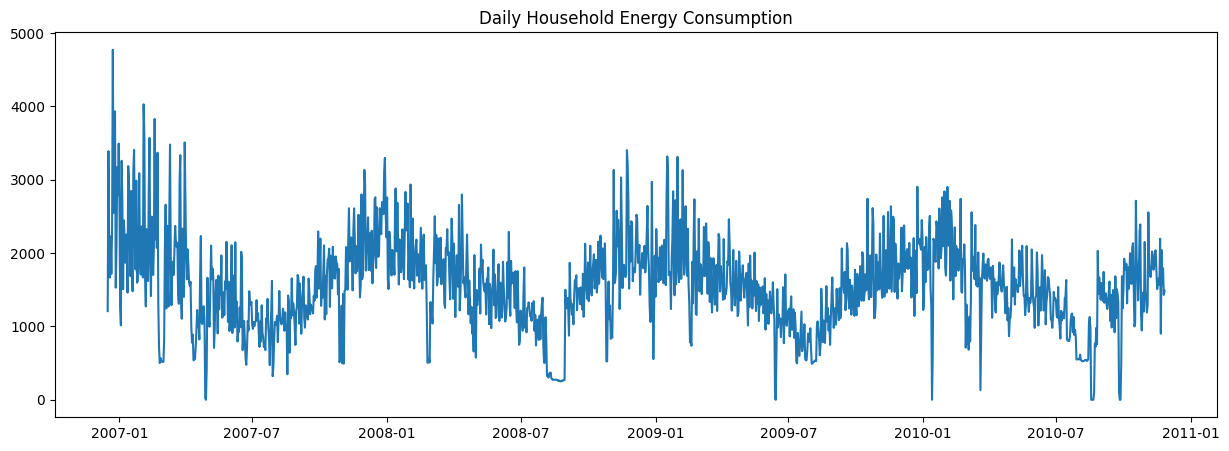

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
# import seaborn as sns
import numpy as np

# Load the data properly
# We read Date and Time as strings first to avoid the 'nested sequence' warning
# find house hold data set on kaggle.
df = pd.read_csv('DataSets/household_power_consumption.txt', sep=';', 
                 low_memory=False, na_values=['?'])

# Combine Date and Time into a single datetime column
df['dt'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], dayfirst=True)
df.set_index('dt', inplace=True)

# Drop the old columns and handle missing values
df.drop(['Date', 'Time'], axis=1, inplace=True)
df.dropna(inplace=True) # Essential for Time Series models

# Resample to Daily
# We sum the energy (Global_active_power) for the whole day
df_daily = df['Global_active_power'].resample('D').sum().to_frame()

print(f"Data loaded! Shape: {df_daily.shape}")
df_daily.head()

# Feature Engineering
def create_features(df):
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    return df

df_daily = create_features(df_daily)

# Visualize the energy usage over time
plt.figure(figsize=(15,5))
plt.plot(df_daily['Global_active_power'])
plt.title('Daily Household Energy Consumption')
plt.show()

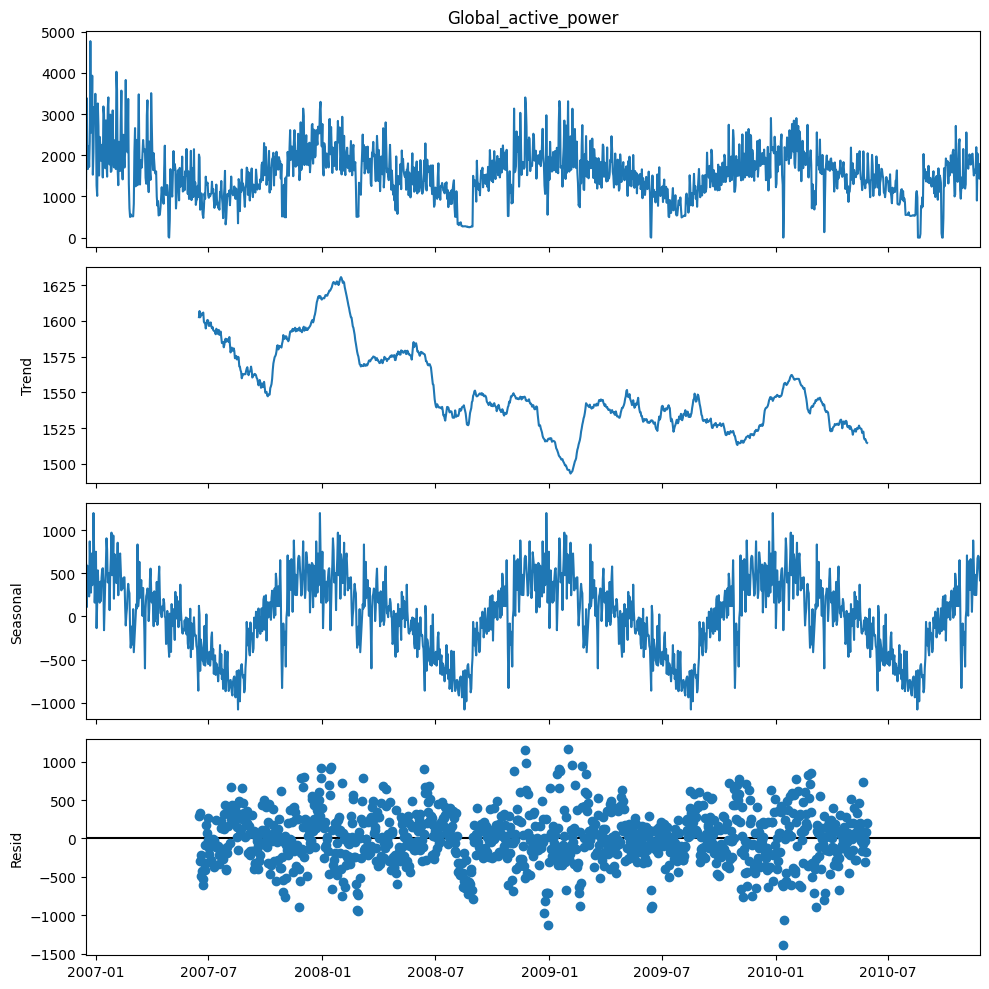

In [2]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Decompose the daily data to see Trend and Seasonality
result = seasonal_decompose(df_daily['Global_active_power'], model='additive', period=365)

plt.rcParams.update({'figure.figsize': (10,10)})
result.plot()
plt.show()

In [3]:
# We check this using the Augmented Dickey-Fuller (ADF) Test:
from statsmodels.tsa.stattools import adfuller

# Run the test
result = adfuller(df_daily['Global_active_power'])

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

if result[1] <= 0.05:
    print("Data is stationary (Ready for ARIMA)")
else:
    print("Data is not stationary (We need to 'difference' it first)")

ADF Statistic: -3.849777
p-value: 0.002437
Data is stationary (Ready for ARIMA)


In [5]:
# ARIMA Model Training
from statsmodels.tsa.arima.model import ARIMA

# Split into Train (80%) and Test (20%)
train_size = int(len(df_daily) * 0.8)
train, test = df_daily.iloc[:train_size], df_daily.iloc[train_size:]

# Simple ARIMA(5,1,0) - a common starting point for daily data
model_arima = ARIMA(train['Global_active_power'], order=(5,1,0))
model_fit = model_arima.fit()

# Forecast
forecast_arima = model_fit.forecast(steps=len(test))

In [7]:
# prophet model training
from prophet import Prophet



# Prepare data for Prophet
df_prophet = train.reset_index().rename(columns={'dt':'ds', 'Global_active_power':'y'})

# Train and Forecast
model_prop = Prophet()
model_prop.fit(df_prophet)
future = model_prop.make_future_dataframe(periods=len(test))
forecast_prop = model_prop.predict(future)
y_pred_prophet = forecast_prop['yhat'].iloc[-len(test):].values

11:22:17 - cmdstanpy - INFO - Chain [1] start processing
11:22:19 - cmdstanpy - INFO - Chain [1] done processing


In [8]:
from xgboost import XGBRegressor

# Use the features we engineered earlier
X_train = train.drop('Global_active_power', axis=1)
y_train = train['Global_active_power']
X_test = test.drop('Global_active_power', axis=1)
y_test = test['Global_active_power']

# Train and Forecast
model_xgb = XGBRegressor(n_estimators=1000, early_stopping_rounds=50, learning_rate=0.01)
model_xgb.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=False)
y_pred_xgb = model_xgb.predict(X_test)

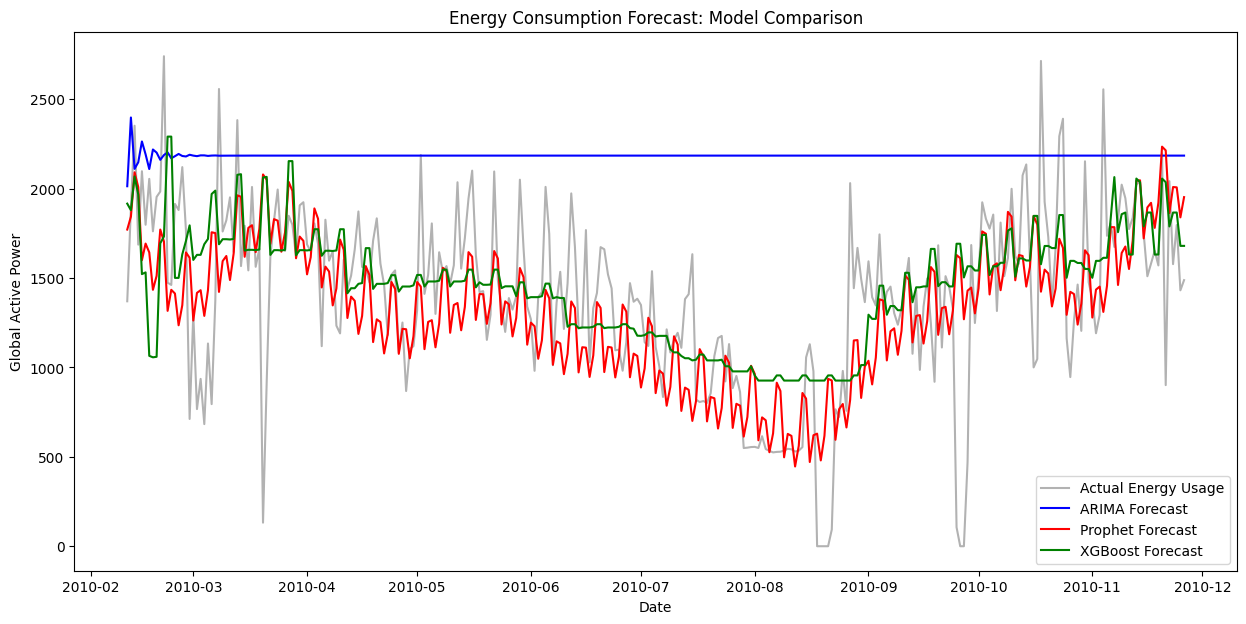

ARIMA RMSE: 933.33
Prophet RMSE: 427.92
XGBoost RMSE: 438.57


In [11]:
plt.figure(figsize=(15, 7))

# Plot Actuals
plt.plot(test.index, y_test, label='Actual Energy Usage', color='black', alpha=0.3)

# Plot Forecasts
plt.plot(test.index, forecast_arima, label='ARIMA Forecast', color='blue')
plt.plot(test.index, y_pred_prophet, label='Prophet Forecast', color='red')
plt.plot(test.index, y_pred_xgb, label='XGBoost Forecast', color='green')

plt.title('Energy Consumption Forecast: Model Comparison')
plt.xlabel('Date')
plt.ylabel('Global Active Power')
plt.legend()
plt.show()

# Print Performance (RMSE - Lower is better)
def rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred)**2))

print(f"ARIMA RMSE: {rmse(y_test, forecast_arima):.2f}")
print(f"Prophet RMSE: {rmse(y_test, y_pred_prophet):.2f}")
print(f"XGBoost RMSE: {rmse(y_test, y_pred_xgb):.2f}")

### 1. Model Performance Comparison
I evaluated three different forecasting approaches to predict household energy consumption. The performance was measured using **Root Mean Squared Error (RMSE)**, where a lower value indicates better accuracy:

| Model | RMSE | Performance Note |
| :--- | :--- | :--- |
| **ARIMA** | 933.33 | Baseline model; struggled to capture complex seasonal patterns. |
| **XGBoost** | 438.57 | Strong performance; effectively used time-based features. |
| **Prophet** | **427.92** | **Winner**; best at handling daily and yearly seasonality. |

### 2. Key Insights
* **Seasonality is King:** The high performance of Prophet suggests that energy consumption in this household is highly dependent on cyclical patterns (e.g., time of day, day of the week, and month of the year).
* **Machine Learning vs. Statistics:** Modern libraries like Prophet and XGBoost provided a ~54% improvement in error reduction over the traditional ARIMA model.
* **Feature Importance:** Engineered features such as `dayofweek` and `month` were crucial for the XGBoost model to understand when "peak" energy usage typically occurs.

### 3. Conclusion
For short-term household energy forecasting, **Prophet** is the most reliable model as it balances accuracy with the ability to handle holiday effects and seasonal shifts automatically.